# Grad-CAM

This notebook implements the Grad-CAM algorithm used in interpretability of Convolutional Networks:

Let $A^l$ be the activation signal of the last spacial layer $l$ in the network,
$$
L = upsample(\partial J/A^l_i,j \odot A^l)
$$

References:

  - https://arxiv.org/pdf/1908.04351.pdf

In [1]:
import tensorflow as tf

LAST_SPACIAL_LAYER = 'top_activation'

REPETITIONS = tf.constant(20)
NOISE = tf.constant(0.2 * 255)

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r '/content/drive/MyDrive/Colab Notebooks/cs-no/6.grads/config' .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from config import config, data, model, utils

from config.utils import to_image, normalize, standardize

utils.setup_clean_image_plotting()

In [4]:
from skimage import color

def plot_segmentation_maps(i, seg):
    result_image = color.label2rgb(seg.numpy(), to_image(i), bg_label=0, bg_color=None)
    utils.plt.imshow(result_image)
    utils.plt.axis('off');

In [5]:
images = data.load_images()
x = model.preprocess(images)

In [6]:
nn = model.build()

logits = nn(x, training=False)
preds = tf.argsort(logits, direction='DESCENDING')
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=5)

In [7]:
nn_s = tf.keras.Model(
    inputs=nn.inputs,
    outputs=[nn.output, nn.get_layer(LAST_SPACIAL_LAYER).output],
    name='model_spacial')

In [8]:
utils.plot(to_image(images), titles=[f'{e[0][1]} {e[0][2]:.0%}'  for e in decoded], rows=4);

Output hidden; open in https://colab.research.google.com to view.

## SmoothGrad

In [9]:
def activation_loss(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

@tf.function
def gradcam(inputs, units):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = activation_loss(y, units)

    dldx, grads = tape.gradient(loss, [inputs, z], unconnected_gradients=tf.UnconnectedGradients.ZERO)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

@tf.function
def smooth_gradients(inputs, units, num_samples=20, noise=.2):
    print(inputs.shape, units.shape)

    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=0, stddev=noise/2)
    
    y = tf.repeat(units, num_samples)
    loss, grads, maps = gradcam(x, y)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(x[i:i+1], preds[i:i+1, 0],
                      REPETITIONS,
                      NOISE)
     for i in range(len(images))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

(1, 300, 300, 3) (1,)


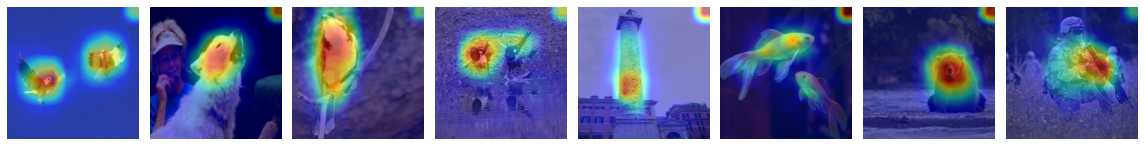

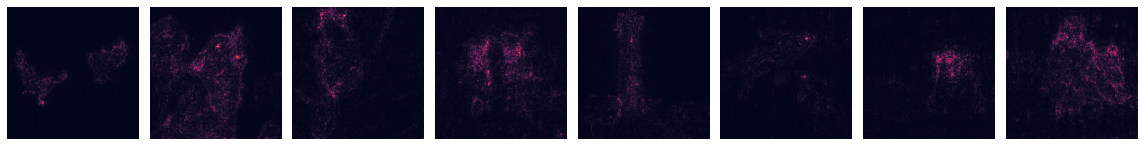

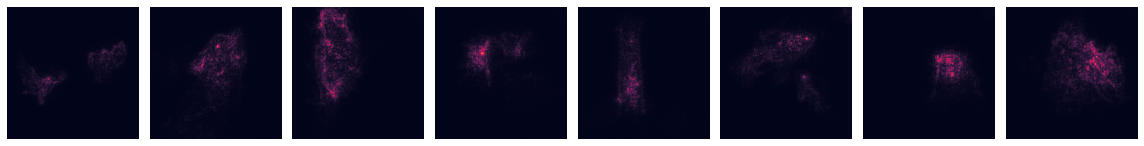

In [10]:
#@title

utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())
utils.plot(gs[:8, ..., 0].numpy())
utils.plot(gm[:8, ..., 0].numpy())

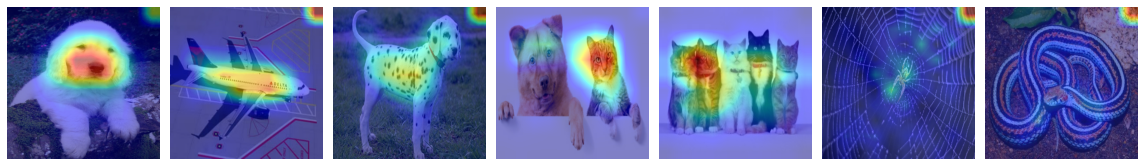

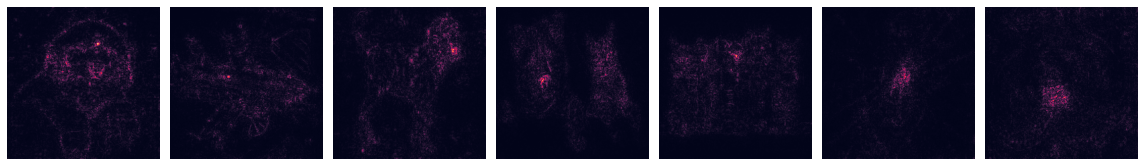

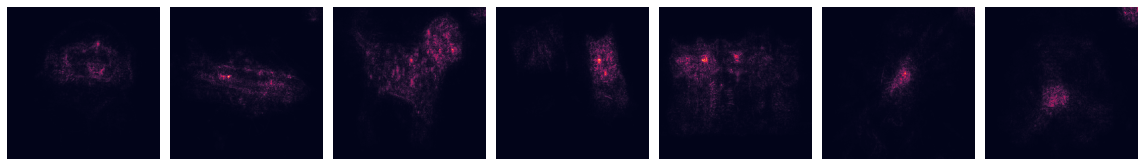

In [11]:
#@title

utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())
utils.plot(gs[8:, ..., 0].numpy())
utils.plot(gm[8:, ..., 0].numpy())

## Min-Max Activation

In [12]:
def gather_sum(y, units):
    return tf.reduce_sum(tf.gather(y, units, axis=1, batch_dims=1), axis=-1)

def min_max_activation_gain(y, positive, negative):
    return gather_sum(y, positive) - gather_sum(y, negative)

@tf.function
def gradcam(inputs, positive, negative):
    with tf.GradientTape(watch_accessed_variables=False) as t:
        t.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = min_max_activation_gain(y, positive, negative)

    dldx, grads = t.gradient(loss, [inputs, z])
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

@tf.function
def smooth_gradients(inputs, positive, negative, num_samples=20, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=0, stddev=noise/2)
    
    positive = tf.repeat(positive, num_samples, axis=0)
    negative = tf.repeat(negative, num_samples, axis=0)
    loss, grads, maps = gradcam(x, positive, negative)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

In [13]:
SAMPLES = [x[7], x[7]]

POSITIVE = tf.constant([[652, 465],
                        [413, 764]])
NEGATIVE = tf.constant([[413, 764],
                        [652, 465]])

SEGMENTS = ['military_uniform', 'assault_rifle']

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(SAMPLES[i:i+1],
                      POSITIVE[i:i+1],
                      NEGATIVE[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(SAMPLES))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

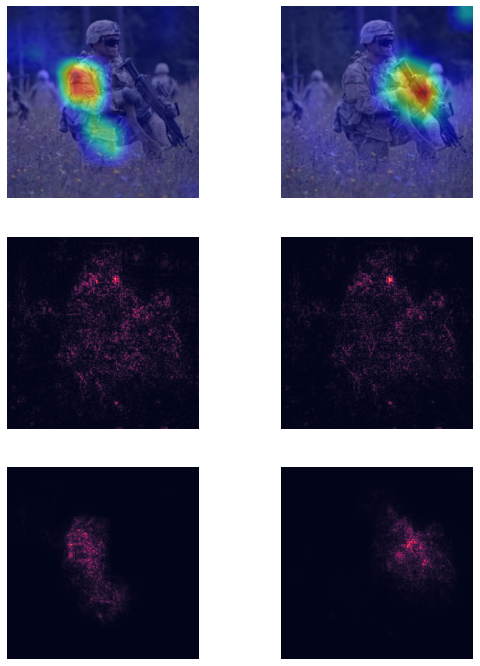

In [14]:
#@title

utils.plt.figure(figsize=(9, 12))
utils.plot_heatmaps(to_image([images[7], images[7]]),
                    maps[..., 0].numpy(),
                    rows=3, cols=2, full=False)
utils.plot(gs[..., 0].numpy(), rows=3, cols=2, full=False, i0=2)
utils.plot(gm[..., 0].numpy(), rows=3, cols=2, full=False, i0=4)

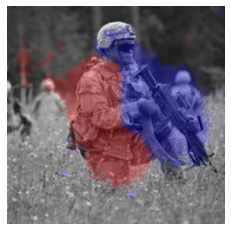

In [15]:
BG_PAD = [[1, 0], [0, 0], [0, 0], [0, 0]]
gmb = tf.pad(gm, BG_PAD, 'CONSTANT', .01)

seg = tf.argmax(gmb, axis=0)[..., 0]
plot_segmentation_maps(images[7], seg)

In [16]:
SAMPLES = [x[11], x[11]]

POSITIVE = tf.constant([[282, 285, 281],
                        [260, 207, 208]])
NEGATIVE = tf.constant([[260, 207, 208],
                        [282, 285, 281]])

SEGMENTS = ['cat', 'dog']

# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(SAMPLES[i:i+1],
                      POSITIVE[i:i+1],
                      NEGATIVE[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(SAMPLES))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

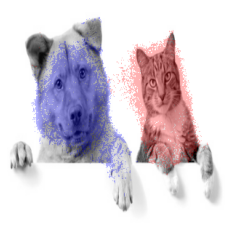

In [17]:
BG_PAD = [[1, 0], [0, 0], [0, 0], [0, 0]]
gmb = tf.pad(gm, BG_PAD, 'CONSTANT', .01)

seg = tf.argmax(gmb, axis=0)[..., 0]
plot_segmentation_maps(images[11], seg)

## FullGrad Backpropagation

In [18]:
def extract_bias(layer):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Batch norm := ((x - m)/s)*w + b
        # Hence bias factor is -m*w/s + b.
        return (
            -layer.moving_mean * layer.gamma
            / tf.sqrt(layer.moving_variance + 1e-07)  # might be variance here.
            + layer.beta)

    if hasattr(layer, 'bias') and layer.bias is not None:
        return layer.bias

def psi(x):
    x = tf.abs(x)
    x = standardize(x)

    return x

In [19]:
layers = [(l, extract_bias(l)) for ix, l in enumerate(nn.layers[1:-1])]
layers = [(l, b) for l, b in layers if b is not None]

intermediates = [l.output for l, _ in layers]
biases = [b for _, b in layers]

print(len(biases), 'layers with bias were found.')

nn_s = tf.keras.Model(nn.inputs, [nn.output, *intermediates], name='spacial_model')

130 layers with bias were found.


In [20]:
def activation_gain(y, positive):
    return gather_sum(y, positive)

def reduce_noise(x, num_samples):
    x = tf.reshape(x, (-1, num_samples, *x.shape[1:]))
    x = tf.reduce_mean(x, axis=1)
    return x

@tf.function
def gradients(inputs, positive):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        y, *ia = nn_s(inputs, training=False)
        loss = activation_gain(y, positive)
    
    grads, *ig = tape.gradient(loss, [inputs, *ia])

    return loss, grads, ig

@tf.function
def smooth_fullgradients(inputs, positive, num_samples=50, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(tf.shape(x), mean=127.5, stddev=255 * noise/2)

    print(x.shape)

    positive = tf.repeat(positive, num_samples, axis=0)

    loss, dydx, dydas = gradients(x, positive)

    fx = dydx * inputs
    fx = reduce_noise(fx, num_samples)
    maps = tf.reduce_sum(psi(fx), axis=-1, keepdims=True)

    Gb = [ig * tf.reshape(b, (1, 1, 1, -1)) for ig, b in zip(dydas, biases)]
    for b in Gb:
        b = reduce_noise(b, num_samples)
        b = psi(b)
        maps += tf.reduce_sum(tf.image.resize(b, config.data.image_size), axis=-1, keepdims=True)
    
    return reduce_noise(loss, num_samples), reduce_noise(dydx, num_samples), maps

In [21]:
SAMPLES = [x[11], x[11]]

POSITIVE = tf.constant([[282],
                        [260]])
# NEGATIVE = tf.constant([[260, 207, 208],
#                         [282, 285, 281]])

SEGMENTS = ['cat', 'dog']

# One image at a time to avoid performance issues with larger models.
r = [smooth_fullgradients(SAMPLES[i:i+1],
                          POSITIVE[i:i+1],
                          # NEGATIVE[i:i+1],
                          REPETITIONS,
                          NOISE)
     for i in range(len(SAMPLES))]

(None, 300, 300, 3)


In [22]:
loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

maps = normalize(maps)

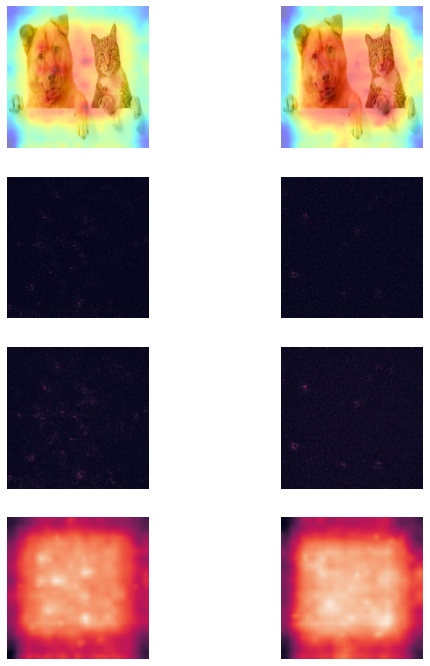

In [24]:
#@title

utils.plt.figure(figsize=(9, 12))
utils.plot_heatmaps(to_image([images[11], images[11]]),
                    maps[..., 0].numpy(),
                    rows=4, cols=2, full=False)
utils.plot(gs[..., 0].numpy(), rows=4, cols=2, full=False, i0=2)
utils.plot(gm[..., 0].numpy(), rows=4, cols=2, full=False, i0=4)
utils.plot(maps[..., 0].numpy(), rows=4, cols=2, full=False, i0=6)

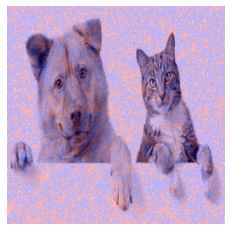

In [25]:
BG_PAD = [[1, 0], [0, 0], [0, 0], [0, 0]]
gmb = tf.pad(gm, BG_PAD, 'CONSTANT', .01)

seg = tf.argmax(gmb, axis=0)[..., 0]
plot_segmentation_maps(images[11], seg)